# Project: ChatControlBot
-------------
Имеется проблема: нужно фильтровать речь в общих телеграм чатах\
Предложенное решение: сделать бота, который сможет анализировать сообщения пользователей и удалять их

По аналогии, можно сделать модель, которая не будет допускать обсуждение определенных тем(например: политика)

План разработки бота:
*   Найти/собрать данные для обучения
*   Предобработать и сделать анализ данных
*   Выбрать метрики 
*   Подобрать и обучить модель
*   Разработать функционал бота
*   Перенести модель



## Import

In [5]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import nltk 
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Сбор данных
Так как для сбора и разметки данных нет реального чата, я буду использовать открытые источники
https://www.kaggle.com/datasets/alexandersemiletov/toxic-russian-comments

Данные собраны из ok.ru\
Каждый комментарий имеет 4 метки
*   NORMAL - обычный комментарий
*   INSULT - комментарии, которые унижают человека
*   THREAT - комментарии с угрозой
*   OBSCENITY - непристойные комментарии

In [8]:
data_list = []
with open("dataset.txt", 'r') as file:
  for line in file:
    # print(line)
    labels = line.split()[0]
    text = line[len(labels)+1:].strip()
    labels = labels.split(",")
    mask = [1 if "__label__NORMAL" in labels else 0,
            1 if "__label__INSULT" in labels else 0,
            1 if "__label__THREAT" in labels else 0,
            1 if "__label__OBSCENITY" in labels else 0]
    data_list.append((text, *mask))

df = pd.DataFrame(data_list, columns=["text", "normal", "insult", "threat", "obscenity"])
df.head(5)

,text,normal,insult,threat,obscenity
0,скотина! что сказать,0,1,0,0
1,я сегодня проезжала по рабочей и между домами ...,1,0,0,0
2,очередной лохотрон. зачем придумывать очередно...,1,0,0,0
3,"ретро дежавю ... сложно понять чужое сердце , ...",1,0,0,0
4,а когда мы статус агрогородка получили?,1,0,0,0


In [9]:
df.isna().sum()

text         0
normal       0
insult       0
threat       0
obscenity    0
dtype: int64

## Предобработка и анализ

In [10]:
for i in df.columns[1:]:
  print(f'{i} - {df[i].sum()}')

normal - 203685
insult - 36826
threat - 12027
obscenity - 4261


In [11]:
# Так как есть сильный дисбаланс классов я сделаю бинарные метки 
# Доброжелательные - 1
# Недорожелательные - 0
def decode_label(x):
  if x['normal']:
    return 1
  else:
    return 0

df['label'] = df[["normal", "insult", "threat", "obscenity"]].apply(decode_label, axis=1)

In [12]:
new_df = df.drop(columns=["normal", "insult", "threat", "obscenity"], axis=1)
new_df.head(5)

,text,label
0,скотина! что сказать,0
1,я сегодня проезжала по рабочей и между домами ...,1
2,очередной лохотрон. зачем придумывать очередно...,1
3,"ретро дежавю ... сложно понять чужое сердце , ...",1
4,а когда мы статус агрогородка получили?,1


In [13]:
print('Недоброжелательные\n')
for i in df[df['label'] == 0]['text'].head(3):
  print(i, '\n')

print('\nДоброжелательные\n')
for i in df[df['label'] == 1]['text'].head(3):
  print(i, '\n')

Недоброжелательные

скотина! что сказать 

заколоть этого плешивого урода что бы крякнул как селезень гандон штопанный всю вакцину ему в бошку что бы конкретно его завернуло 

долбоебы это фэйк 


Доброжелательные

я сегодня проезжала по рабочей и между домами снитенко и гомолысовой магазином ( на пустыре) бежала кошка похожего окраса. может, я и ошиблась, но необычный окрас бросился в глаза. 

очередной лохотрон. зачем придумывать очередной налог на воздух, если можно обьявить инсульт и грипп- пандемией! и лихо на придурках зарабатывать годами на штрафах, фейковых вакцинах, всевозможных платных тестах, продажей масок и перчаток по баснословным ценам.. самое смешное, что бараны блеют и верят пастуху, телевизору. живут как под гипнозом. не думая, не глядя по сторонам. 

ретро дежавю ... сложно понять чужое сердце , лиш ощутить музыкой видимо 



In [14]:
# Превращаем текст в цифру
snowball = SnowballStemmer(language='russian')
stop_words_russian = stopwords.words('russian')

def tokenize_text(text, del_stop_words=True):
  tokens = word_tokenize(text, language='russian')
  tokens = [i for i in tokens if i not in string.punctuation]
  if del_stop_words:
    tokens = [i for i in tokens if i not in stop_words_russian]
  tokens = [snowball.stem(i) for i in tokens]
  return tokens

In [ ]:
tokenize_text(new_df.iloc[0]['text'])

['скотин', 'сказа']

In [ ]:
# Создаем свой vectorizer
vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenize_text(x, del_stop_words=True))

In [ ]:
train_df, test_df = train_test_split(new_df, test_size=0.2)

In [ ]:
print(train_df['label'].value_counts(), '\n')
print(test_df['label'].value_counts())

1    162935
0     35697
Name: label, dtype: int64 

1    40750
0     8908
Name: label, dtype: int64


In [ ]:
features = vectorizer.fit_transform(train_df['text'])

## Выбор метрики
Ограничение:
Из 100 случаев, классифицированных как недоброжелательные, только в 5 модель может ошибиться.

При таком ограничении:\
Precision ≥ 0.95\
Recall -> max

In [ ]:
# Сделаем функцию для получения метрик модели
def metric(model, X, y):
  print(f'precision - {round(precision_score(y, model.predict(X)), 3)}')
  print(f'recall - {round(recall_score(y, model.predict(X)), 3)}')
  prec, rec, thresholds = precision_recall_curve(y, model.predict_proba(X)[:, 1] ) 
  plot_precision_recall_curve(estimator=model, X=X, y=y);
  plt.show()
  return prec, rec, thresholds

# функция для регулирования порога функции
def metric_threshold(model, X, y, threshold):
  pr = precision_score(y, model.predict_proba(X)[:, 1]>threshold)
  print(f'precision - {round(pr, 3)}')
  rec = recall_score(y, model.predict_proba(X)[:, 1]>threshold)
  print(f'precision - {round(rec, 3)}')

## Обучение модели

In [ ]:
# Сделаем pipeline
vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenize_text(x, del_stop_words=True))
model = LogisticRegression()

model_Pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('model', model)
])

model_Pipeline.fit(train_df['text'], train_df['label'])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7f1e85e9e050>)),
                ('model', LogisticRegression())])

precision - 0.953
recall - 0.992


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


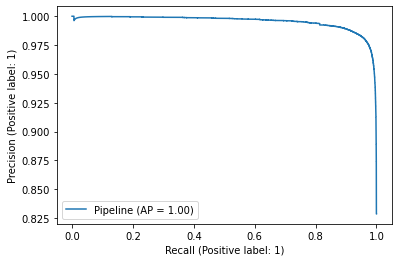

In [ ]:
prec, rec, thresholds = metric(model_Pipeline, test_df['text'], test_df['label'])

In [ ]:
threshold = thresholds[np.where(prec > 0.95)[0][0]]
metric_threshold(model_Pipeline, test_df['text'], test_df['label'], threshold)

precision - 0.95
precision - 0.993


Полученные результаты полностью удовлетворяют ограничения и показывают хорошие метрики.\
Однако, несмотря на слишком высокие результаты на тестовой выборке, на реальных данных модель может вести себя не лучшим образом

## Функционал бота
- Реагирование на недоброжелательные предложения (бан пользователя; удаление сообщения; предупреждение)
- обучение в реальном времени
- изменение уровня толерантности 

Для простоты будет реализован бот, отправляющий предупреждения пользователям

## Перенос модели 
Для сохранения весов модели будет использоваться модуль dill, так как он способен сохранять lambda функции


In [ ]:
import dill

In [ ]:
model_Pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=lambda x: tokenize_text(x, del_stop_words=True))),
    ('model', LogisticRegression())
])

model_Pipeline.fit(new_df['text'], new_df['label'])

In [ ]:
with open('model.pkl','wb') as f:
    dill.dump(model_Pipeline, f)

In [ ]:
with open("model.pkl", 'rb') as f:
    model = dill.load(f)

## Заключение
Получилась простая модель, которая способна решать простые задачи фильтрации. 

Недостатки модели:
- Модель не реагирует на большие количество неизвестных ей слов, которые несут негативный характер
- Модель не лучшим образом подготовлена для работы в чате


Предложения по улучшению модели:
- Обучить на новых данных, взятых из реального чата 
- Использовать более сильную модель. Например уже обученную нейронную сеть, у которой можно изменить последний слой для нашей задачи.
- Так как модель работает в чате, можно улучшить её, используя контекст нескльких сообщений пользователя с разным весом текста, в зависимости от времени отправки сообщения. Например, имеетя 3 сообщения от пользователя, которые он отправил в разное время; итоговое предсказание будет находиться как среднее между предсказаниями всех сообщения с учетом коэффициента, учитывающего время каждого сообщения.